In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import pandas as pd
import astropy as ap
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from datetime import datetime

import histlite as hl
import csky as cy

from glob import glob
%matplotlib inline
mpl.style.use('/home/apizzuto/Nova/python3/scripts/novae_plots.mplstyle')

In [3]:
greco_base = '/data/user/apizzuto/Nova/GRECO_Skylab_Dataset/v2.2/'

data_fs = sorted(glob(greco_base + 'IC86_20*data_with_angErr.npy'))
exp = [np.load(data) for data in data_fs]
exp = np.hstack(exp)
mc = np.load(greco_base + 'IC86_2012.numu_with_angErr.npy')
grls = sorted(glob(greco_base + 'GRL/IC86_20*data.npy'))
grl = [np.load(g) for g in grls]
grl = np.hstack(grl)

greco = cy.selections.CustomDataSpecs.CustomDataSpec(exp, mc, np.sum(grl['livetime']), 
                                                     np.linspace(-1., 1., 31),
                                                     np.linspace(0., 4., 31), 
                                                     grl=grl, key='GRECOv2.2', cascades=True)

ana_dir = cy.utils.ensure_dir('/data/user/apizzuto/csky_cache/greco_ana')
greco_ana = cy.get_analysis(cy.selections.repo, greco, dir=ana_dir)

Setting up Analysis for:
GRECOv2.2
Setting up GRECOv2.2...
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.


In [44]:
tab = Table.read('/home/apizzuto/Nova/source_list/appendix.tex')
df = tab.to_pandas()
coords = SkyCoord(frame="galactic", l=df['$l$']*u.degree, b=df['$b$']*u.degree)
equatorial = coords.icrs
df['ra'] = equatorial.ra.deg
df['dec'] = equatorial.dec.deg
df['gamma'] = [~np.char.startswith(fl, '$<$') for fl in df['Flux']] 
df = df.replace(['-'], np.nan)
df[u'$t_2$'] = df[u'$t_2$'].astype(float)

In [45]:
df = df[~df['gamma']]
df['$t_2$'][np.isnan(df['$t_2$'])] = 10.
df['mjd'] = np.array([Time.strptime(pt, '%Y-%m-%d').mjd for pt in df['Peak Time']])
during_greco = (df['mjd'] > greco_ana.mjd_min) * (df['mjd'] + df['$t_2$'] < greco_ana.mjd_max)
df = df[during_greco]

/home/apizzuto/.venvs/py3_env/lib/python3.6/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


In [56]:
ras = df['ra']
decs = df['dec']
delta_t = df['$t_2$']

conf = {'extended': True,
       'space': "ps",
        'time': "transient",
        'sig': 'transient',
        #'energy': "customflux",
        #'flux': cy.hyp.PowerLawFlux(2),
       #'cut_n_sigma': 5.
       }

src = cy.utils.Sources(ra=np.radians(ras), dec=np.radians(decs), mjd=mjds, sigma_t=np.zeros_like(delta_t), t_100=delta_t * 0.5)

cy.CONF['src'] = src
cy.CONF['mp_cpus'] = 10

tr = cy.get_trial_runner(conf, ana=greco_ana, src=src)
n_trials=1000
bg = cy.dists.Chi2TSD(tr.get_many_fits(n_trials))

Performing 1000 background trials using 10 cores:
       1000/1000 trials complete.   


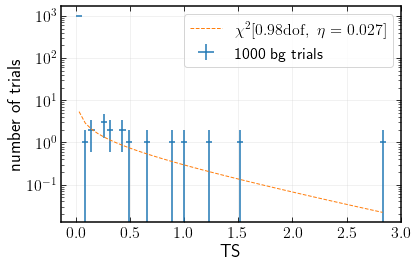

In [57]:
fig, ax = plt.subplots()

h = bg.get_hist(bins=50)
hl.plot1d(ax, h, crosses=True,
          label='{} bg trials'.format(bg.n_total))

x = h.centers[0]
norm = h.integrate().values
ax.semilogy(x, norm * bg.pdf(x), lw=1, ls='--',
            label=r'$\chi^2[{:.2f}\mathrm{{dof}},\ \eta={:.3f}]$'.format(bg.ndof, bg.eta))

ax.set_xlabel(r'TS')
ax.set_ylabel(r'number of trials')
ax.legend()
plt.tight_layout()

In [58]:
n_sigs = np.r_[:101:10]

trials = [tr.get_many_fits(100, n_sig=n_sig, logging=False, seed=n_sig) for n_sig in n_sigs]
for (n_sig, t) in zip(n_sigs, trials):
    t['ntrue'] = np.repeat(n_sig, len(t))
allt = cy.utils.Arrays.concatenate(trials)

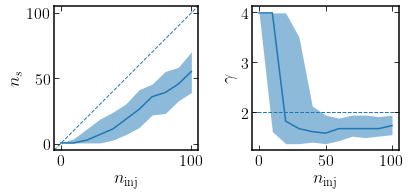

In [59]:
fig, axs = plt.subplots(1, 2, figsize=(6,3))

dns = np.mean(np.diff(n_sigs))
ns_bins = np.r_[n_sigs - 0.5*dns, n_sigs[-1] + 0.5*dns]
expect_kw = dict(color='C0', ls='--', lw=1, zorder=-10)
expect_gamma = tr.sig_injs[0].flux[0].gamma

ax = axs[0]
h = hl.hist((allt.ntrue, allt.ns), bins=(ns_bins, 100))
hl.plot1d(ax, h.contain_project(1),errorbands=True, drawstyle='default')

lim = ns_bins[[0, -1]]
ax.set_xlim(ax.set_ylim(lim))
ax.plot(lim, lim, **expect_kw)
ax.set_aspect('equal')


ax = axs[1]
h = hl.hist((allt.ntrue, allt.gamma), bins=(ns_bins, 100))
hl.plot1d(ax, h.contain_project(1),errorbands=True, drawstyle='default')
ax.axhline(expect_gamma, **expect_kw)
ax.set_xlim(axs[0].get_xlim())

for ax in axs:
    ax.set_xlabel(r'$n_\mathrm{inj}$')
    ax.grid()
axs[0].set_ylabel(r'$n_s$')
axs[1].set_ylabel(r'$\gamma$')

plt.tight_layout()

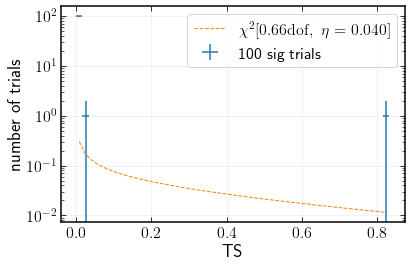

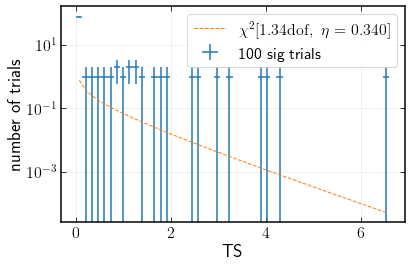

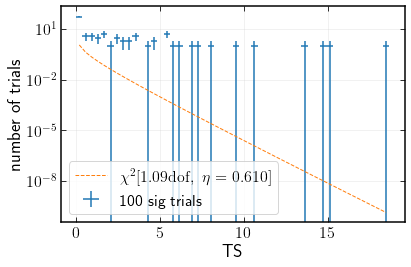

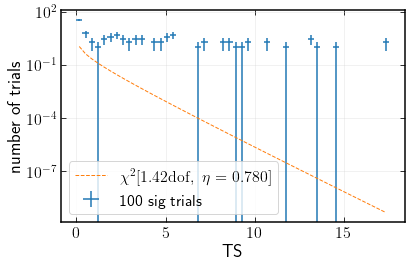

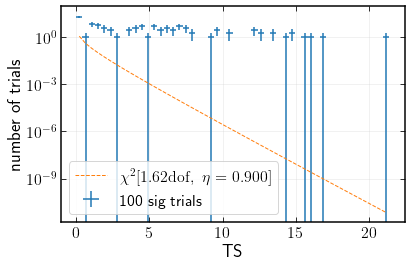

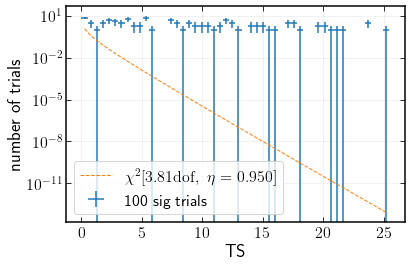

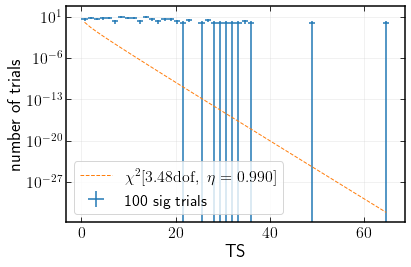

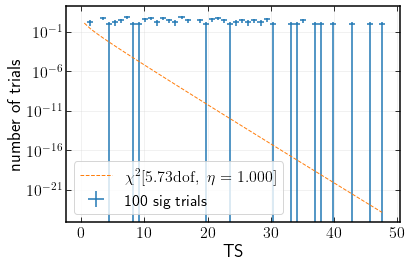

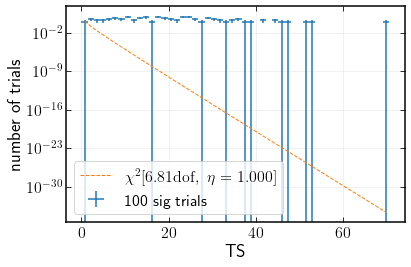

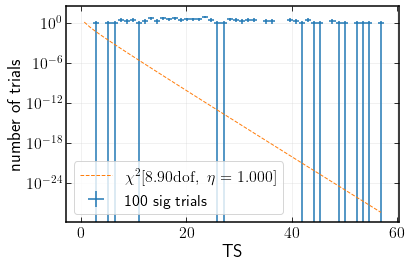

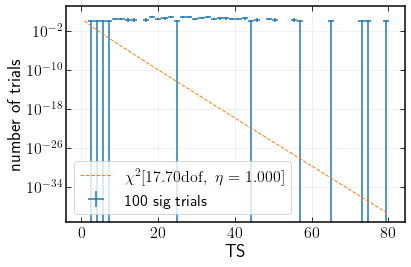

In [61]:
for trial in trials:
    fig, ax = plt.subplots()

    dist = cy.dists.Chi2TSD(trial)
    h = dist.get_hist(bins=50)
    hl.plot1d(ax, h, crosses=True,
              label='{} sig trials'.format(dist.n_total))

    x = h.centers[0]
    norm = h.integrate().values
    ax.semilogy(x, norm * bg.pdf(x), lw=1, ls='--',
                label=r'$\chi^2[{:.2f}\mathrm{{dof}},\ \eta={:.3f}]$'.format(dist.ndof, dist.eta))

    ax.set_xlabel(r'TS')
    ax.set_ylabel(r'number of trials')
    ax.legend()
    plt.tight_layout()
    plt.show()